In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from tqdm.notebook import tqdm 
from google.colab import drive
from glob import glob 

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/collage/segmentation')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
sample_imgs = glob('/sample_image/*')
save_path = '/sample_image/result'

model_present_path = '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/model_weight/last_full_train/last_full_train.h5'
model = tf.keras.models.load_model(model_present_path)

In [21]:
def read_image(image_path, original=False):
    '''
    이미지를 tensorflow 턴서 형태로 읽어오는 함수

    image_path : str / 이미지의 경로
    original : bool / 원본형태를 유지할 것인지 세그멘테이션 모델에 들어갈 수 있는 크기로 정규화 및 리사이즈 할 것인지
    '''
    IMAGE_SIZE = 512
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    if not original:
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image/255
    return image

In [ ]:
def plot_predictions(images_list, model, figsize=5):
    _, axes = plt.subplots(nrows=len(images_list), ncols=3, figsize=(figsize*3, len(images_list)*5))
    for i, image_file in enumerate(images_list):
        original_image = read_image(image_file, original=True)
        input_image = read_image(image_file)
        input_pred = model.predict(input_image[np.newaxis,...])
        thresh_hold = 0.4
        pred_mask = input_pred > thresh_hold
        alpha = cv2.resize(np.squeeze(np.where(pred_mask, 1.0,0)), (original_image.shape[1], original_image.shape[0]))

        color_mask = np.stack([alpha*255, np.zeros(alpha.shape[:2]), np.zeros(alpha.shape[:2]) ], axis=2)
        ori_img = np.array(original_image).astype(np.float32)
        dst = cv2.addWeighted(ori_img, 0.8, color_mask, 0.2 , 0,  dtype = cv2.CV_32F)

        axes[i][0].imshow(original_image)
        axes[i][1].imshow(alpha)
        axes[i][2].imshow(dst/255)

In [ ]:
imgs = glob('/content/drive/MyDrive/Colab Notebooks/collage/segmentation/data/rawdata/humanparsing/val/Images/*')


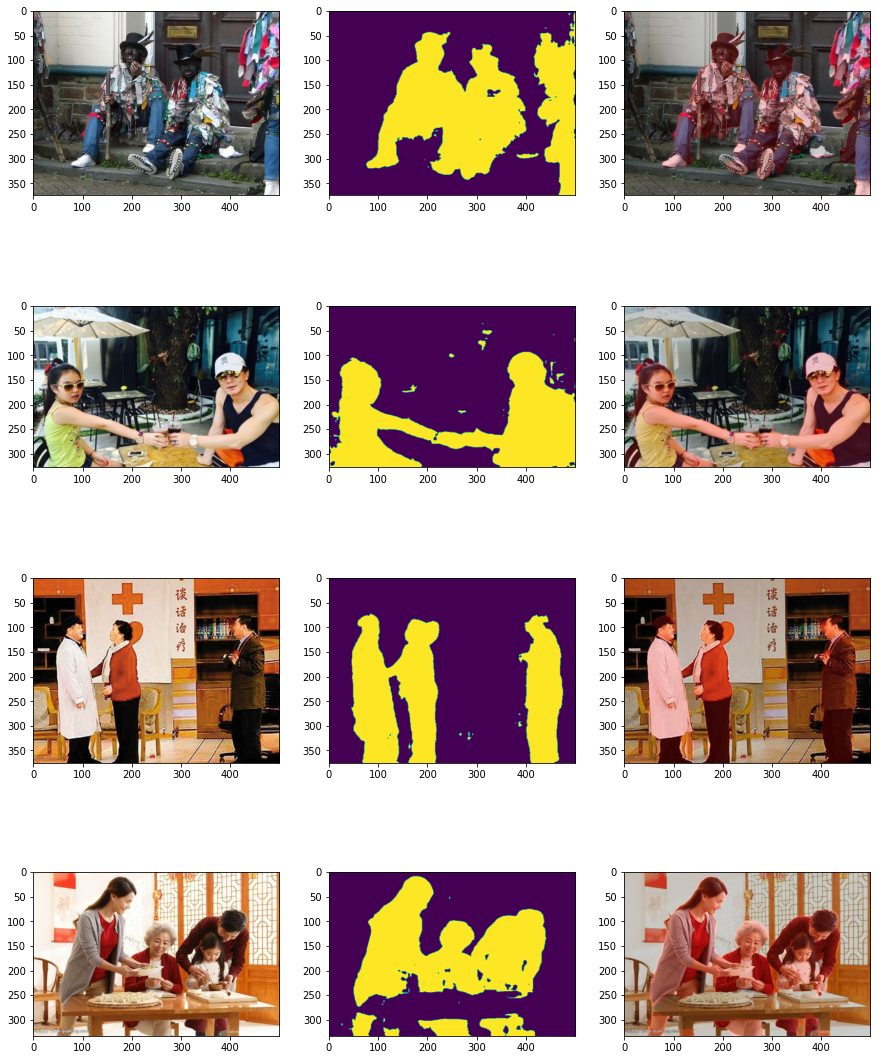

In [ ]:
plot_predictions(np.random.choice(imgs, size=4, replace=False, p=None),model)

In [ ]:
samples = sorted(glob('/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/*jpg') + glob('/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/*png'))
print(samples)

['/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/bae.jpg', '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/chin.jpg', '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/jimin.jpg', '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/luda.jpg', '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/ma.jpg', '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/moon.jpg', '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/poong.jpg', '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/son.png', '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/taeyeon.jpg']


In [22]:
image_path  = '/content/drive/MyDrive/Colab Notebooks/collage/segmentation/sample_image/sh.jpg'
save_path = image_path.replace('sample_image', 'sample_image/result').replace('.jpg','.png')

original_image = read_image(image_path, original=True)
input_image = read_image(image_path)
# 모델로 예측을 실행
input_pred = model.predict(input_image[np.newaxis,...])
# 사람에 해당하는 픽셀이라고 예측할 기준
thresh_hold = 0.5
# 기준에 따라 마스크 생성
pred_mask = input_pred > thresh_hold
# 마스크를 원본이미지의 사이즈로 복원
alpha = cv2.resize(np.squeeze(np.where(pred_mask, 1.0,0)), (original_image.shape[1], original_image.shape[0]))
alpha = np.where(alpha>0,1,0).astype(np.float32)
# 마스크에 구멍이 있을 경우
try:
    # 다리사이 같은 부분을 컨투어로 인식하는 것을 방지하기위해 제로패딩
    pad_num = 50
    paddings = tf.constant([[pad_num, pad_num], [pad_num, pad_num]])
    padded = np.array(tf.pad(alpha, paddings, "CONSTANT"))
    # 마스크의 구멍을 확인하고 채움
    contours_coor ,info = cv2.findContours(padded.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    info_ = np.where(info[0][:,-1]==-1)[0]
    for i, num in enumerate(info_):
        contour_coor = contours_coor[num]
        if i == 0:
            filled_hole = cv2.fillPoly(padded.astype(np.uint8), [np.squeeze(contour_coor)], 255)
        else :
            filled_hole = cv2.fillPoly(filled_hole, [np.squeeze(contour_coor)], 255)
    filled_hole_ = filled_hole[pad_num:padded.shape[0]-pad_num, pad_num:padded.shape[1]-pad_num]
    filed_mask = np.where(filled_hole_[...,np.newaxis] > 0, 1,0)
    masked_image = original_image * filed_mask
    masked_image_png = np.concatenate([masked_image[:,:,2][...,np.newaxis], masked_image[:,:,1][...,np.newaxis],
                                    masked_image[:,:,0][...,np.newaxis] ,(filed_mask).astype(np.uint8)*255], axis=2)
# 마스크에 구멍이 없을 경우
except:
    alpha_ = alpha[...,np.newaxis]
    masked_image = original_image * alpha_
    masked_image_png = np.concatenate([masked_image[:,:,2][...,np.newaxis], masked_image[:,:,1][...,np.newaxis],
                                    masked_image[:,:,0][...,np.newaxis], (alpha_).astype(np.uint8)*255 ], axis=2)
    


cv2.imwrite(save_path, masked_image_png)

True

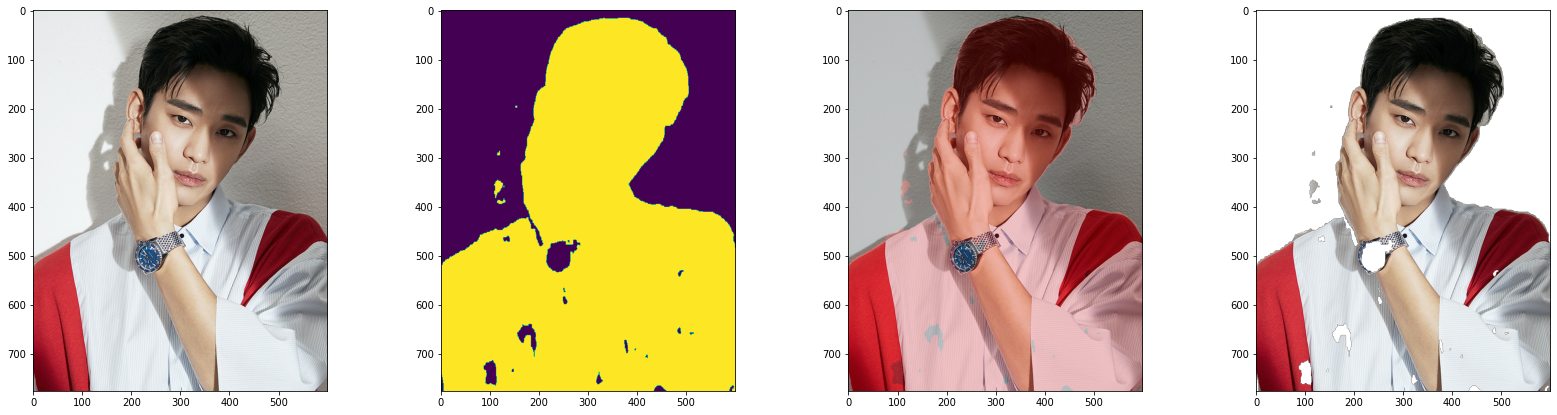

In [23]:
# 모델 예측후 보정이전

fig, axs = plt.subplots(1,4, figsize=(28,7))

color_mask = np.stack([alpha*255, np.zeros(alpha.shape[:2]), np.zeros(alpha.shape[:2]) ], axis=2)
ori_img = np.array(original_image).astype(np.float32)
dst = cv2.addWeighted(ori_img, 0.8, color_mask, 0.2 , 0,  dtype = cv2.CV_32F) 

axs[0].imshow(original_image)
axs[1].imshow(alpha)
axs[2].imshow(dst/255)
axs[3].imshow(np.dstack([np.array(original_image * alpha[...,np.newaxis], dtype=np.float32), alpha[...,np.newaxis]*255])/255)

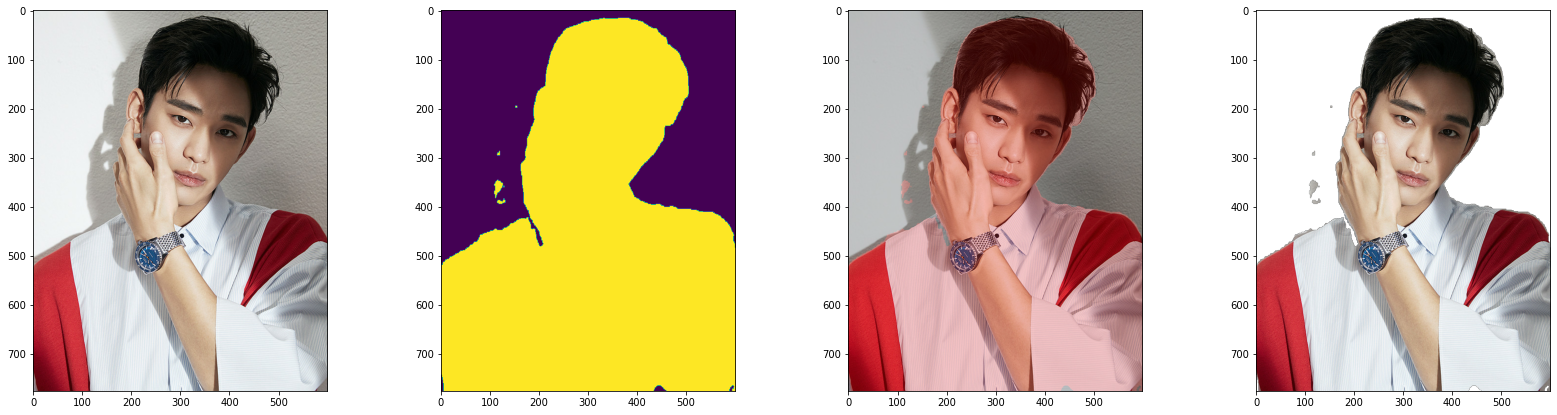

In [24]:
# 모델의 결과에 구멍이 있는 경우 채우는 방식으로 후처리
fig, axs = plt.subplots(1,4, figsize=(28,7))

color_mask = np.stack([np.squeeze(filed_mask*255), np.zeros(filed_mask.shape[:2]), np.zeros(filed_mask.shape[:2]) ], axis=2)
ori_img = np.array(original_image).astype(np.float32)
dst = cv2.addWeighted(ori_img, 0.8, color_mask, 0.2 , 0,  dtype = cv2.CV_32F) 

axs[0].imshow(original_image)
axs[1].imshow(np.squeeze(filed_mask))
axs[2].imshow(dst/255)
axs[3].imshow(cv2.cvtColor(masked_image_png, cv2.COLOR_BGRA2RGBA))